In [1]:
# Import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import loguniform

# Preprocessing and feature selection
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, LabelBinarizer, MinMaxScaler
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.inspection import permutation_importance
from sklearn.manifold import TSNE

# Model selection and evaluation
from sklearn.model_selection import cross_val_predict, train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, confusion_matrix, precision_recall_curve, make_scorer, ConfusionMatrixDisplay

# Resampling techniques
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Classifiers
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier

# SHapley Additive exPlanations
import shap

g:\Anaconda3\envs\Project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Step1: Load DataSet

In [2]:
# Read the Data Set
path = 'df_faults_even.xlsx'
DF_faulty = pd.read_excel(path, index_col=0) # With New Features

In [3]:
# Data Preparation
df_trial = DF_faulty.copy()

# Retain only the samples of 'BPS', 'BPL'
remaining_faults = ['BPS', 'BPL']
df_trial = df_trial[df_trial['Fault'].isin(remaining_faults)]

X_full = df_trial.drop(columns=['Datetime', 'Fault'])
y_full = df_trial["Fault"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42, stratify=y_full)

# Training sets
train_df = X_train.copy()
train_df['Fault'] = y_train

# Testing set
test_df = X_test.copy()
test_df['Fault'] = y_test

# Shape
print(f"Training DataFrame shape: {train_df.shape}")
print(f"Testing DataFrame shape: {test_df.shape}")

# Class distribution of training dataset
class_distribution = train_df['Fault'].value_counts()
print("Class distribution in the training set:")
print(class_distribution)

# Class distribution of testing dataset
class_distribution_test = test_df['Fault'].value_counts()
print("Class distribution in the testing set:")
print(class_distribution_test)

Training DataFrame shape: (14016, 114)
Testing DataFrame shape: (3504, 114)
Class distribution in the training set:
Fault
BPS    7008
BPL    7008
Name: count, dtype: int64
Class distribution in the testing set:
Fault
BPS    1752
BPL    1752
Name: count, dtype: int64


### Prepare Training and Testing Dataset

In [4]:
# Prepare Data (Training and Testing)
df_train = train_df.copy()
df_test = test_df.copy()

# Features
X_train = df_train.drop(columns=['Fault'])
X_test = df_test.drop(columns=['Fault'])

# Label Encoding
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(df_train['Fault'])
y_test_encoded = encoder.transform(df_test['Fault'])

# Define the target faults for binary classification (BPS vs BPL)
target_faults = encoder.transform(["BPL"])  # 1:BPL, 0:BPS
y_train_binary = np.where(np.isin(y_train_encoded, target_faults), 1, 0)
y_test_binary = np.where(np.isin(y_test_encoded, target_faults), 1, 0)

# Step2: Training Phase

# Base Mdoels Selection: SHAP (SHapley Additive exPlanations)

In [5]:
# Store the predictions of base models
base_model_predictions = []
meta_targets = []

# Base models
base_models = [
    ("GB", GradientBoostingClassifier(random_state=42)),
    ("DT", DecisionTreeClassifier(random_state=42)),
    ("RF", RandomForestClassifier(random_state=42, n_jobs=-1)),
    ("XGB", XGBClassifier(random_state=42, n_jobs=-1)),
    ("LightGBM", LGBMClassifier(random_state=42, n_jobs=-1, verbosity=-1)),
    ("CatBoost", CatBoostClassifier(random_state=42, verbose=0)),
]

# Meta-model
meta_model = GradientBoostingClassifier(random_state=42)

# Stratified 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_index, test_index) in enumerate(skf.split(X_train, y_train_binary), 1):
    X_cv_train, X_cv_val = X_train.iloc[train_index], X_train.iloc[test_index]
    y_cv_train, y_cv_val = y_train_binary[train_index], y_train_binary[test_index]
    
    # SMOTE for training data
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_cv_train, y_cv_train)

    # Train and test for each base model in the current fold
    fold_predictions = []
    for name, model in base_models:
        model.fit(X_train_resampled, y_train_resampled)
        # Get probability predictions (of class 1)
        if hasattr(model, 'predict_proba'):
            preds = model.predict_proba(X_cv_val)[:, 1]
        else:
            preds = model.predict(X_cv_val)
        fold_predictions.append(preds)
    
    # Stack the predictions each base model
    fold_predictions = np.column_stack(fold_predictions)
    base_model_predictions.append(fold_predictions)
    meta_targets.append(y_cv_val)

# Combine predictions from all folds as new input features for the meta-model
X_meta = np.vstack(base_model_predictions)
y_meta = np.concatenate(meta_targets)

print(f'Shape of meta features: {X_meta.shape}')

Shape of meta features: (14016, 6)


In [6]:
# Train the meta-model
meta_model.fit(X_meta, y_meta)

# SHAP analysis
explainer = shap.TreeExplainer(meta_model)
shap_values = explainer.shap_values(X_meta)

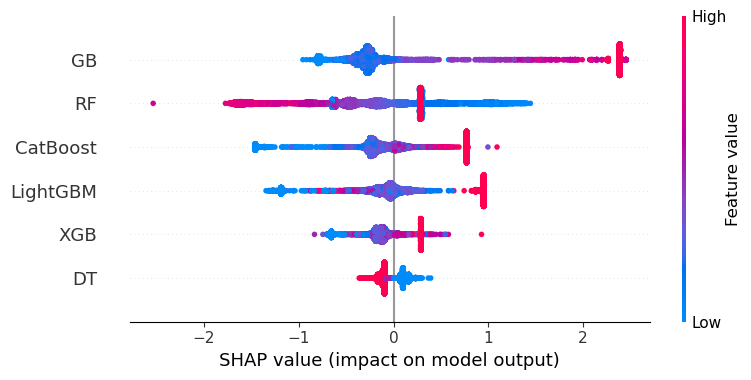

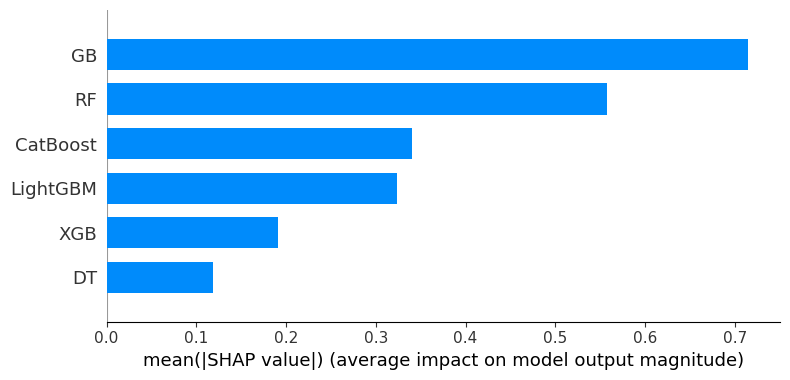

In [7]:
# Get base model names for feature names
base_model_names = [name for name, _ in base_models]

# Visualize SHAP values
shap.summary_plot(shap_values, X_meta, feature_names=base_model_names)
shap.summary_plot(shap_values, X_meta, plot_type='bar', feature_names=base_model_names)

## Step2.2: Feature Selection

### 2.2.1 Feature Importances with Cross-Validation

In [5]:
# Define the base models and meta-model
base_models = [
    ("GB", GradientBoostingClassifier(random_state=42)),
    #("DT", DecisionTreeClassifier(random_state=42)),
    ("RF", RandomForestClassifier(random_state=42, n_jobs=-1)),
    ("XGB", XGBClassifier(random_state=42, n_jobs=-1)),
    #("LightGBM", LGBMClassifier(random_state=42, n_jobs=-1, verbosity=-1)),
    ("CatBoost", CatBoostClassifier(random_state=42, verbose=0, thread_count=-1)),
]

# Stratified 5-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

feature_importances = {name: [] for name, _ in base_models}
for train_idx, val_idx in cv.split(X_train, y_train_binary):
    X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_cv_train, y_cv_val = y_train_binary[train_idx], y_train_binary[val_idx]
    
    for name, model in base_models:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=42)),
            ('classifier', model)
        ])
        pipeline.fit(X_cv_train, y_cv_train)

        feature_importances[name].append(pipeline.named_steps['classifier'].feature_importances_) # Aggregate the Feature Importances

# Step 1: Average the feature importances across the CV folds for each base model
mean_importances_per_model = {name: np.mean(importances, axis=0) for name, importances in feature_importances.items()}

# Step 2: Normalize these feature importances independently
scaler = MinMaxScaler()
normalized_importances_per_model = {name: scaler.fit_transform(mean_importances.reshape(-1, 1)).flatten() for name, mean_importances in mean_importances_per_model.items()}

# Step 3: Average the normalized feature importances across all base models
mean_importances_across_models = np.mean(list(normalized_importances_per_model.values()), axis=0)

# Resutls
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': mean_importances_across_models
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

               Feature  Importance
33           CT_FLOW_1    0.702252
102       CT_TotalFLOW    0.485686
112  Relative_Humidity    0.307509
107     CDWL_DeltaFLOW    0.284193
87   CT_ApproachTEMP_1    0.278880
..                 ...         ...
44            CT_STA_3    0.000000
14     CHL_RWCD_TEMP_3    0.000000
11           CHL_POW_3    0.000000
42            CT_STA_1    0.000000
29        CT_FAN_SPD_3    0.000000

[113 rows x 2 columns]


### Visuazliation of Feature Importances

['CT_FLOW_1', 'CT_TotalFLOW', 'Relative_Humidity', 'CDWL_DeltaFLOW', 'CT_ApproachTEMP_1', 'OA_TEMP_WB', 'OA_TEMP', 'TWV_CTRL', 'CDWL_POW', 'CDWL_PM_POW_1', 'CDWL_Error', 'CDWL_SW_TEMP', 'CHL_RWCD_TEMP_1', 'CDWL_RW_TEMP', 'CHL_SWCD_TEMP_1', 'CWL_SEC_RW_TEMP', 'CT_RW_TEMP_1', 'CHL_POW_1', 'CWL_SEC_SW_TEMP', 'PLANT_POW_1', 'CT_SW_TEMP_1', 'CT_DeltaTEMP_1', 'CT_Dist_1', 'CHL_COP_1', 'CWL_SEC_LOAD', 'CDWL_Load', 'CT_Error_1', 'CDWL_DeltaTEMP', 'CWL_SEC_CW_FLOW', 'CT_FAN_SPD_1']


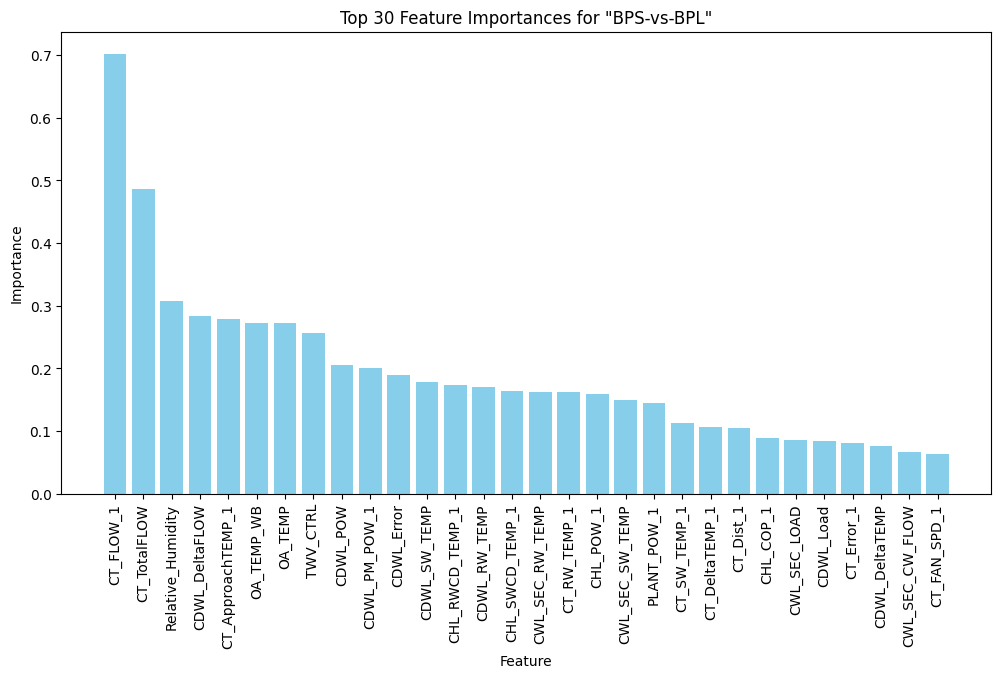

In [6]:
# Number of features
TOP_N = 30
top_features = feature_importance_df.head(TOP_N)['Feature'].tolist()
print(top_features)

# Plot Feature Importances Graph
plt.figure(figsize=(12, 6))
plt.bar(feature_importance_df.head(TOP_N)['Feature'], 
        feature_importance_df.head(TOP_N)['Importance'], 
        color='skyblue')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title(f'Top {TOP_N} Feature Importances for "BPS-vs-BPL"')
plt.xticks(rotation=90)
plt.show()

# ['Relative_Humidity', 'CT_FLOW_1', 'CT_TotalFLOW', 'OA_TEMP', 'CT_ApproachTEMP_1', 'OA_TEMP_WB', 'CDWL_DeltaFLOW', 'TWV_CTRL', 'CDWL_Error', 'CDWL_RW_TEMP', 'CDWL_PM_POW_1', 'CDWL_SW_TEMP', 'CWL_SEC_RW_TEMP', 'CHL_POW_1', 'CDWL_POW', 'CHL_COP_1']

### Feature Importance Ranking Based Sequential Forward Feature Selection (FIR-SFFS)

In [7]:
# Define the base models and meta-model
base_models = [
    ("GB", GradientBoostingClassifier(random_state=42)),
    #("DT", DecisionTreeClassifier(random_state=42)),
    ("RF", RandomForestClassifier(random_state=42, n_jobs=-1)),
    ("XGB", XGBClassifier(random_state=42, n_jobs=-1)),
    #("LightGBM", LGBMClassifier(random_state=42, n_jobs=-1, verbosity=-1)),
    ("CatBoost", CatBoostClassifier(random_state=42, verbose=0, thread_count=4)),
]


meta_model = GradientBoostingClassifier(random_state=42)
model_BPSL = StackingClassifier(estimators=base_models, final_estimator=meta_model, n_jobs=-1, passthrough=True)

# Stratified 5-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


feature_f1_scores = {}
for n in range(2, 31, 1):  # Change the step size if needed
    X_features = X_train[top_features[:n]]

    # Define the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model_BPSL)
    ])

    # Cross-Validation
    cv_results = cross_val_score(pipeline, X_features, y_train_binary, cv=cv, scoring='f1_macro', n_jobs=-1)

    # Mean of F1 scores
    mean_f1_score = np.mean(cv_results)

    # Store the result
    feature_f1_scores[n] = mean_f1_score
    print(f"Top {n} Features - Mean F1 Score: {mean_f1_score:.4f}")

# Convert results to DataFrame
f1_results_df = pd.DataFrame(list(feature_f1_scores.items()), columns=['Num_Features', 'F1_Score'])

Top 2 Features - Mean F1 Score: 0.6437
Top 3 Features - Mean F1 Score: 0.6445
Top 4 Features - Mean F1 Score: 0.6427
Top 5 Features - Mean F1 Score: 0.7146
Top 6 Features - Mean F1 Score: 0.7409
Top 7 Features - Mean F1 Score: 0.7485
Top 8 Features - Mean F1 Score: 0.7521
Top 9 Features - Mean F1 Score: 0.7504
Top 10 Features - Mean F1 Score: 0.7533
Top 11 Features - Mean F1 Score: 0.7550
Top 12 Features - Mean F1 Score: 0.7560
Top 13 Features - Mean F1 Score: 0.7603
Top 14 Features - Mean F1 Score: 0.7550
Top 15 Features - Mean F1 Score: 0.7562
Top 16 Features - Mean F1 Score: 0.7514
Top 17 Features - Mean F1 Score: 0.7567
Top 18 Features - Mean F1 Score: 0.7592
Top 19 Features - Mean F1 Score: 0.7623
Top 20 Features - Mean F1 Score: 0.7585
Top 21 Features - Mean F1 Score: 0.7607
Top 22 Features - Mean F1 Score: 0.7588
Top 23 Features - Mean F1 Score: 0.7491
Top 24 Features - Mean F1 Score: 0.7507
Top 25 Features - Mean F1 Score: 0.7503
Top 26 Features - Mean F1 Score: 0.7499
Top 27 F

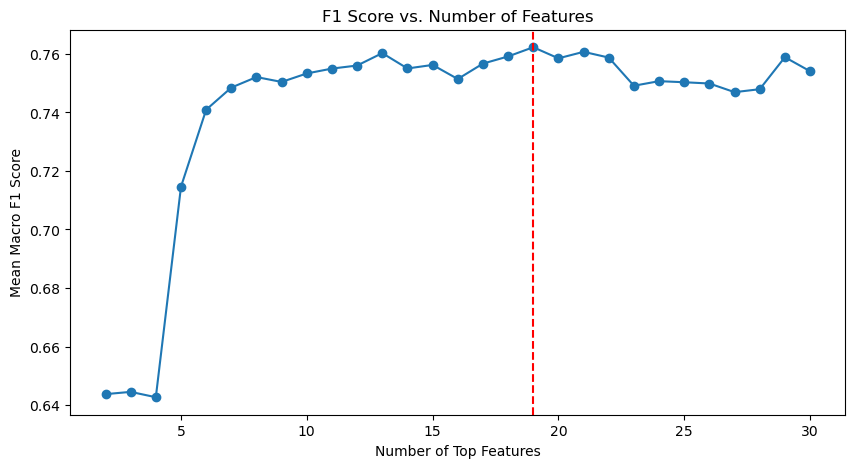

In [8]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(f1_results_df['Num_Features'], f1_results_df['F1_Score'], marker='o', linestyle='-')
plt.xlabel('Number of Top Features')
plt.ylabel('Mean Macro F1 Score')
plt.title('F1 Score vs. Number of Features')
plt.axvline(x=19, color='r', linestyle='--') # Peak or Elbow Point
plt.show()

# Hyper-Parameter Searching

In [ ]:
X_train_features = X_train[top_features[:19]]

# Base models
base_models = [
    ("Gradient Boosting", GradientBoostingClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42, n_jobs=-1)),
    ("XGBoost", XGBClassifier(random_state=42, n_jobs=-1)),
    ("CatBoost", CatBoostClassifier(random_state=42, verbose=0, thread_count=-1)),
]
meta_model = GradientBoostingClassifier(random_state=42)
model_BPSL = StackingClassifier(estimators=base_models, final_estimator=meta_model, n_jobs=-1, passthrough=True)

# Parameter grid for both base models and meta-model
param_grid = {

    # Meta-model parameters (GB)
    'classifier__final_estimator__learning_rate': [0.1, 0.2],  # Default: 0.1
    'classifier__final_estimator__n_estimators': [100, 200],  # Default: 100
    'classifier__final_estimator__max_depth': [1, 3, 5],  # Default: 3
    
    # Gradient Boosting parameters
    'classifier__Gradient Boosting__learning_rate': [0.1, 0.2],  # Default: 0.1
    'classifier__Gradient Boosting__n_estimators': [100, 300],  # Default: 100
    'classifier__Gradient Boosting__max_depth': [1, 3, 5],  # Default: 3
    
    # RandomForest parameters
    'classifier__Random Forest__n_estimators': [100, 300],  # Default: 100
    'classifier__Random Forest__min_samples_leaf': [1, 2],  # Default: 1
    'classifier__Random Forest__max_features': ['sqrt', 'log2', 0.75],  # Default: 'sqrt'
    
    # XGBoost parameters
    'classifier__XGBoost__learning_rate': [0.2, 0.3],  # Default: 0.3
    'classifier__XGBoost__n_estimators': [100, 300],  # Default: 100
    'classifier__XGBoost__subsample': [0.85, 1.0],  # Default: 1.0
    'classifier__XGBoost__gamma': [0, 0.1, 0.2],  # Default: 0
    
    # CatBoost parameters
    'classifier__CatBoost__learning_rate': [0.01, 0.03, 0.05],  # Default: 0.03
    'classifier__CatBoost__depth': [4, 6, 8],  # Default: 6
    'classifier__CatBoost__iterations': [800, 1000],  # Default: 1000
}

# Step 3: Pipeline for SMOTE, Scaling, and Classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', model_BPSL)
])

# RandomizedSearchCV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid, n_iter=300, n_jobs=-1,  verbose=3,  scoring='f1_macro', cv=skf, random_state=42)
random_search.fit(X_train_features, y_train_binary)

# Results
results_df = pd.DataFrame(random_search.cv_results_)
results_df = results_df.sort_values(by='mean_test_score', ascending=False)
#print(results_df)

print(f"Best parameters found: {random_search.best_params_}")
print(f"Best Mean F1 Score (CV): {random_search.best_score_:.4f}")

"""

Best parameters found: {
'classifier__final_estimator__n_estimators': 200, 

'classifier__XGBoost__subsample': 0.85, 
'classifier__XGBoost__n_estimators': 300, 
'classifier__XGBoost__learning_rate': 0.2, 

'classifier__Random Forest__n_estimators': 300, 

'classifier__Gradient Boosting__n_estimators': 300, 
'classifier__Gradient Boosting__max_depth': 5, 
}

Best Mean F1 Score (CV): 0.7664
"""

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Best parameters found: {'classifier__final_estimator__n_estimators': 200, 'classifier__final_estimator__max_depth': 3, 'classifier__final_estimator__learning_rate': 0.1, 'classifier__XGBoost__subsample': 0.85, 'classifier__XGBoost__n_estimators': 300, 'classifier__XGBoost__learning_rate': 0.2, 'classifier__XGBoost__gamma': 0, 'classifier__Random Forest__n_estimators': 300, 'classifier__Random Forest__min_samples_leaf': 1, 'classifier__Random Forest__max_features': 'sqrt', 'classifier__Gradient Boosting__n_estimators': 300, 'classifier__Gradient Boosting__max_depth': 5, 'classifier__Gradient Boosting__learning_rate': 0.1, 'classifier__CatBoost__learning_rate': 0.03, 'classifier__CatBoost__iterations': 1000, 'classifier__CatBoost__depth': 6}
Best Mean F1 Score (CV): 0.7664


# Tamp: Testing Phase (Model Evaluation)

### Testing Dataset

Classification Report:
              precision    recall  f1-score   support

         BPS       0.75      0.88      0.81      1752
         BPL       0.86      0.71      0.78      1752

    accuracy                           0.80      3504
   macro avg       0.80      0.80      0.79      3504
weighted avg       0.80      0.80      0.79      3504

F1-Score for BPSL: 0.7936


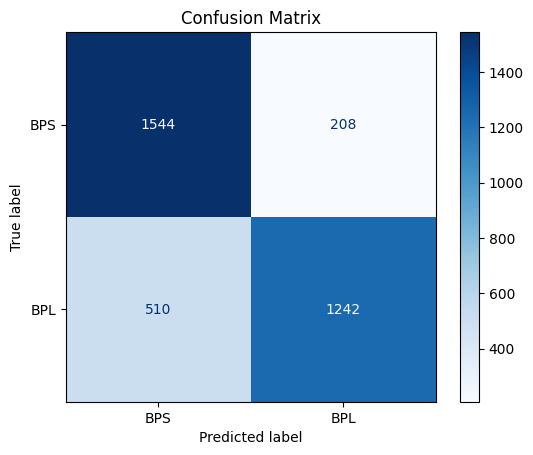

In [ ]:
# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrames format
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Model Building
X_train_features = X_train_scaled_df[top_features[:19]]
X_test_features = X_test_scaled_df[top_features[:19]]

# SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_features, y_train_binary)

# Base models
base_models = [
    ("Gradient Boosting", GradientBoostingClassifier(n_estimators=300, max_depth=5, learning_rate=0.1, random_state=42)),
    ("Random Forest", RandomForestClassifier(n_estimators=300, min_samples_leaf=1, random_state=42, max_features='sqrt', n_jobs=-1)),
    ("XGBoost", XGBClassifier(subsample=0.85, n_estimators=300, learning_rate=0.2, gamma=0, random_state=42, n_jobs=-1)),
    ("CatBoost", CatBoostClassifier(learning_rate=0.03, iterations=1000, depth=6, random_state=42, verbose=0, thread_count=-1))
]
meta_model = GradientBoostingClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, random_state=42)

model_BPSL = StackingClassifier(estimators=base_models, final_estimator=meta_model, n_jobs=-1, passthrough=True)
model_BPSL.fit(X_train_resampled, y_train_resampled)

# Prediction
y_pred = model_BPSL.predict(X_test_features)

target_names = ['BPS', 'BPL']
# Classification Report
print("Classification Report:")
print(classification_report(y_test_binary, y_pred, target_names=target_names))

# F1-Score for Positive Class (BPX)
BPSL_score = f1_score(y_test_binary, y_pred, average='macro')
print(f"F1-Score for BPSL: {BPSL_score:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test_binary, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
